# 大問2

## 計算環境
MacBook Pro (13-inch, 2016, Two Thunderbolt 3 ports)

プロセッサ: 2 GHz Intel Core i5

メモリ: 8 GB 1867 MHz LPDDR3

ソフト: Jupyter notebook (5.4.0)

言語: Python 3.6.4

## (1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

### 問題設定

Aは1000次

bは1000次で各値は1から100までのfloat型の乱数を作成した(乱数はseedをとって各手法で固定した)

In [2]:
# 次数の設定
degree = 1000

# 反復回数の設定
n_iteration = 1000

In [3]:
# A: 本レポートではtridiagonal_matrix(2), tridiagonal_matrix(20)を用いる
def tridiagonal_matrix(c, n = degree):
    A = np.zeros([n, n])
    for i in range(n):
        if i == 0:
            A[i,i] = c 
            A[i, i+1] = -1
        elif i == n - 1:
            A[i, i - 1] = -1
            A[i, i] = c
        else:
            A[i, i - 1] = -1
            A[i, i] = c
            A[i, i + 1] = -1
    return A

# b
def constant_vector(n = degree):
    b = np.zeros([n, 1])
    np.random.seed(23)
    for i in range(n):
        b[i] = np.random.uniform()
    return b

### 実装

誤差のノルムをあとで観察するために「||Ax - b|| < εなら処理とめてreturnする」のような処理はあえて入れていません。

逆行列は一度求めればその後掛け算するだけで使えるため、計算してしまっています

#### Jacobi法

In [4]:
def jacobi(A, b = constant_vector(), x_0 = np.ones([degree, 1]), n_itr = n_iteration):
    xs = np.array([x_0])
    D = np.diag(np.diag(A))
    LU = A - D
    D_inv = np.linalg.inv(D)
    constant_params = [-1 * D_inv @ LU, D_inv @ b]
    for k in range(n_itr):
        xs = np.append(xs, [constant_params[0] @ xs[k] + constant_params[1]], axis = 0)
    return xs

#### GS法

In [5]:
def gs(A, b = constant_vector(), x_0 = np.ones([degree, 1]), n_itr = n_iteration):
    xs = np.array([x_0])
    LD_inv = np.linalg.inv(np.tril(A))
    U = np.triu(A, 1)
    constant_params = [-1 * LD_inv @ U, LD_inv @ b]
    for k in range(n_itr):
        xs = np.append(xs, [constant_params[0] @ xs[k] + constant_params[1]], axis = 0)
    return xs

#### SOR法

In [6]:
def sor(A, b = constant_vector(), x_0 = np.ones([degree, 1]), omega = 1.2, n_itr = n_iteration):
    xs = np.array([x_0])
    U = np.triu(A, 1)
    L = np.tril(A, 1)
    D = np.diag(np.diag(A))
    constant_params = [np.linalg.inv(D + omega * L) @ ((1 - omega) * D - omega * U), omega * np.linalg.inv(D + omega * U) @ b]
    for k in range(n_itr):
        xs = np.append(xs, [constant_params[0] @ xs[k] + constant_params[1]], axis = 0)
    return xs

#### CG法

In [7]:
def cg(A, b = constant_vector(), x_0 = np.ones([degree, 1]), n_itr = n_iteration):
    xs = np.array([x_0])
    r = b - A @ xs[0]
    p = r
    for k in range(n_itr):
        alpha = (r.T @ p) / (p.T @ A @ p)
        xs = np.append(xs, [xs[k] + alpha * p], axis = 0)
        r = r - alpha * A @ p
        beta = -1 * (r.T @ A @ p) / (p.T @ A @ p)
        p = r + beta * p
    return xs

### 検証

In [8]:
def plot_errors(c):
    A = tridiagonal_matrix(c)
    
    error = lambda x: np.linalg.norm(A @ x - constant_vector())

    jacobi_error_transition = list(map(error, jacobi(A)))
    gs_error_transition = list(map(error, gs(A)))
    sor_error_transition = list(map(error, sor(A)))
    cg_error_transition = list(map(error, cg(A)))

    cnt = np.arange(n_iteration + 1)
    plt.plot(cnt, jacobi_error_transition, label='Jacobi法')
    plt.plot(cnt, gs_error_transition, label='Gauss-Seidel法')
    plt.plot(cnt, sor_error_transition, label='SOR法')
    plt.plot(cnt, cg_error_transition, label='CG法')
    
    plt.legend()
    plt.title("||Ax = b||の推移, c = {}(cond(A) = {})の時".format(c, np.linalg.cond(A)))
    plt.xlabel('反復回数 (k)')
    plt.ylabel('||Ax_k - b||')
    plt.grid()
    plt.show()

In [9]:
def plot_errors_by_log(c):
    A = tridiagonal_matrix(c)
    
    error = lambda x: np.log10(np.linalg.norm(A @ x - constant_vector()))

    jacobi_error_transition = list(map(error, jacobi(A)))
    gs_error_transition = list(map(error, gs(A)))
    sor_error_transition = list(map(error, sor(A)))
    cg_error_transition = list(map(error, cg(A)))

    cnt = np.arange(n_iteration + 1)
    plt.plot(cnt, jacobi_error_transition, label='Jacobi法')
    plt.plot(cnt, gs_error_transition, label='Gauss-Seidel法')
    plt.plot(cnt, sor_error_transition, label='SOR法')
    plt.plot(cnt, cg_error_transition, label='CG法')
    
    plt.legend()
    plt.title("log_10||Ax = b||の推移, c = {}(cond(A) = {})の時".format(c, np.linalg.cond(A)))
    plt.xlabel('反復回数 (k)')
    plt.ylabel('log_10(||Ax_k - b||)')
    plt.grid()
    plt.show()

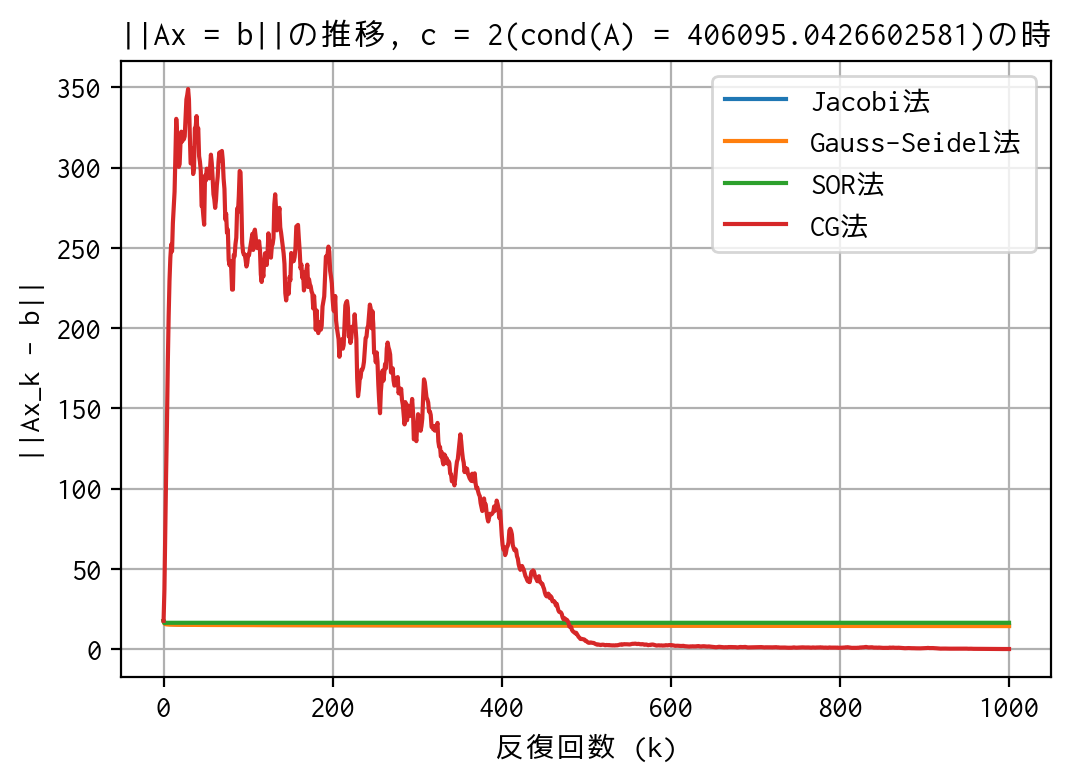

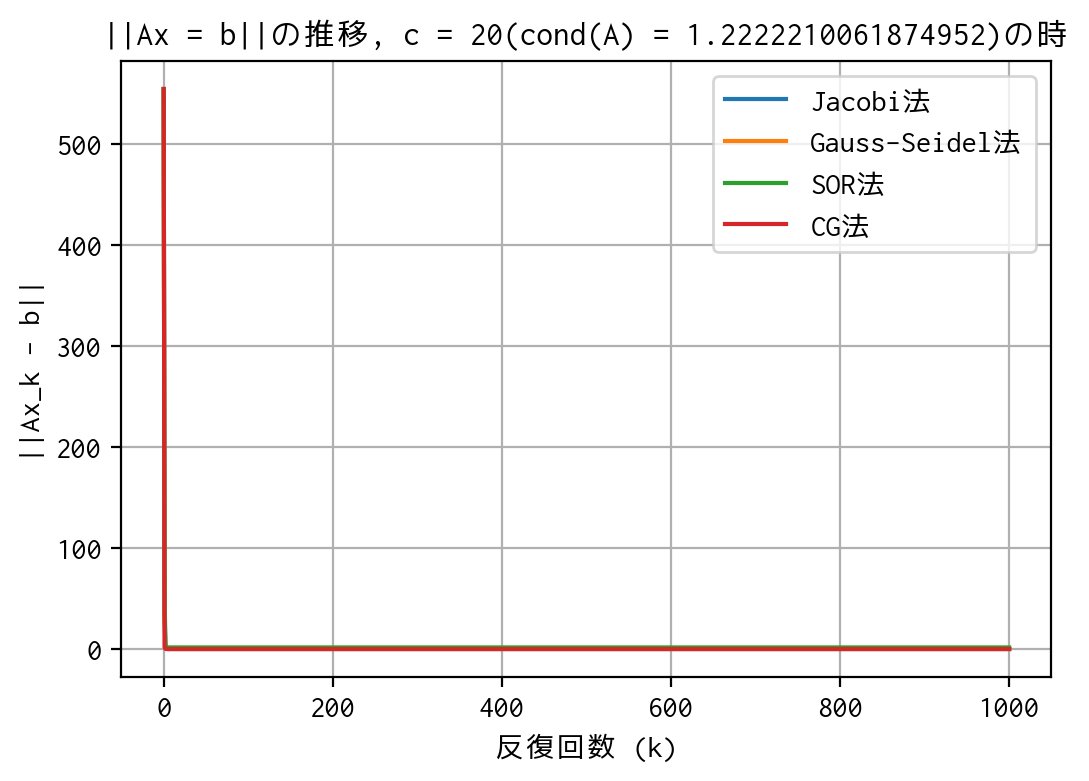

In [10]:
plot_errors(2)
plot_errors(20)

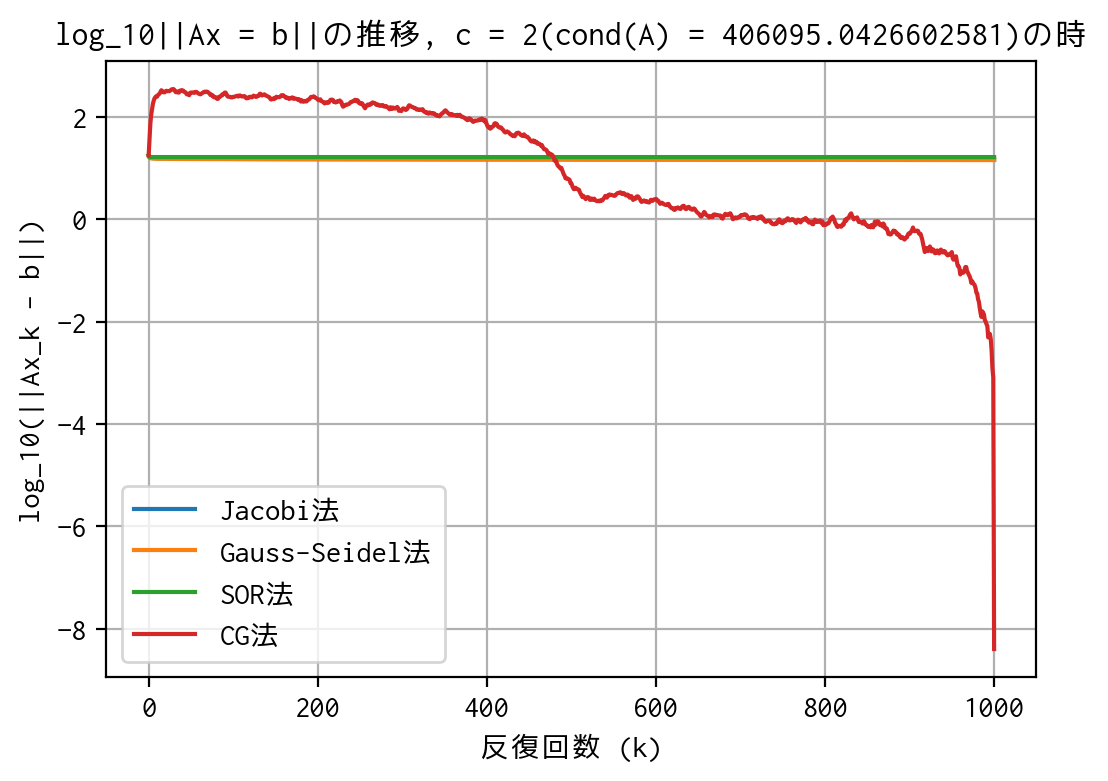

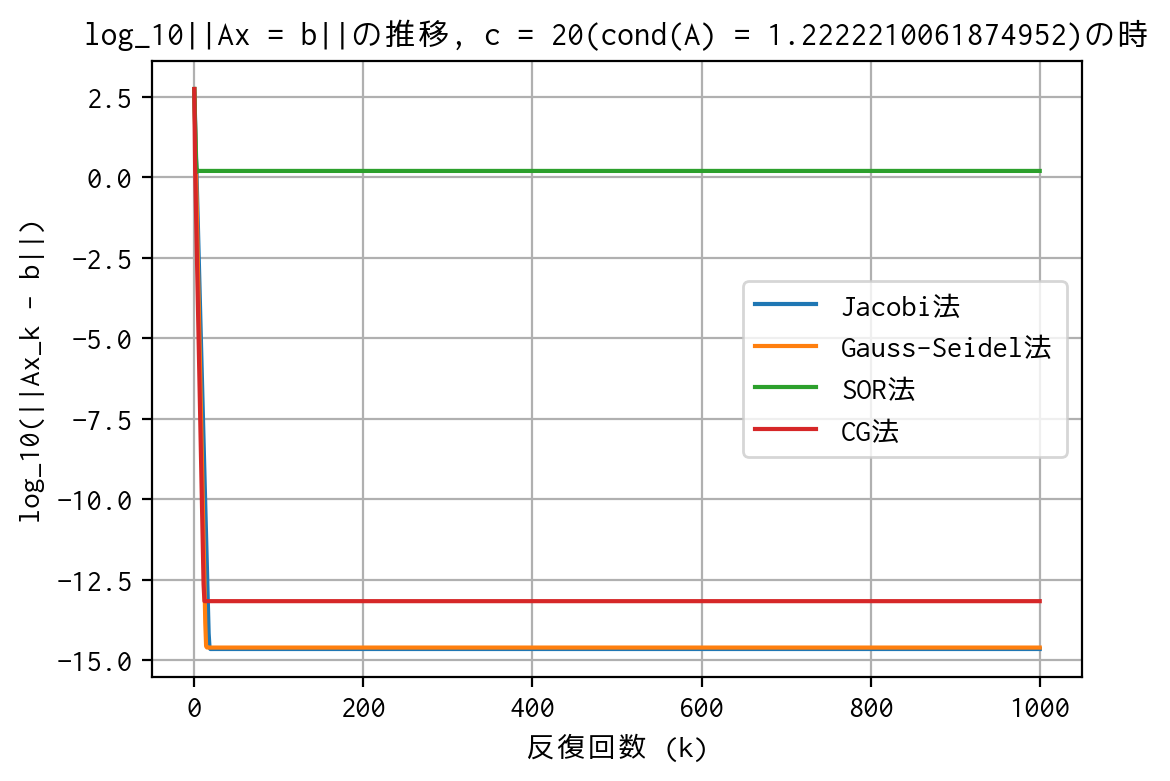

In [11]:
plot_errors_by_log(2)
plot_errors_by_log(20)

## (2) 考察

#### c = 2 と c = 20 での違い

In [12]:
print("c = 2の時の条件数: ", np.linalg.cond(tridiagonal_matrix(2)))
print("c = 20の時の条件数: ", np.linalg.cond(tridiagonal_matrix(20)))

c = 2の時の条件数:  406095.0426602581
c = 20の時の条件数:  1.2222210061874952


c = 20ではどの手法でも急速に||Ax - b||が0に近づいているのに対し、c = 2で||Ax - b||が1000回の反復で0に収束していっているように見えるのは、CG法以外だけであった。

上のように、c = 2 と c = 20 とで条件数が大きく異なるが、この現象はこの条件数の差が大きく影響を及ぼしていると考えられる。

#### 各手法の比較

CG法以外の定常反復法ではほぼ一様に||Ax-b||の値が0に近づいているように見える。

一方、CG方では、反復回数が小さい時に誤差が急激に大きくなるが、c = 2でもc = 20でも、反復を500回程度繰り返したあたりから急速に収束に向かい、1000回程度反復したあとは他の手法に比べ、誤差が非常に小さくなっている。